In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib import rc
from IPython import display


# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('text', usetex=True)

In [2]:
path = "rt-polaritydata/rt-polaritydata/"

pos_path = os.path.join(path, 'rt-polarity.pos')
neg_path = os.path.join(path, 'rt-polarity.neg')

def load_review(path, is_pos=True):
    with open(path) as f:
        review = pd.DataFrame({'review':f.read().splitlines()})
    review['sentiment'] = 1 if is_pos else 0
    return review

pos_review = load_review(pos_path, is_pos=True)
neg_review = load_review(neg_path, is_pos=False)

all_reviews = pd.concat([pos_review, neg_review])
all_reviews.head()

,review,sentiment
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


#### Load word2vec model

In [3]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin", binary=True)

In [4]:
queen = word2vec_model["king"] - word2vec_model["man"] + word2vec_model["woman"]
word2vec_model.similar_by_vector(queen)

[('king', 0.8449392318725586),
 ('queen', 0.7300517559051514),
 ('monarch', 0.6454660892486572),
 ('princess', 0.6156250834465027),
 ('crown_prince', 0.5818676352500916),
 ('prince', 0.577711820602417),
 ('kings', 0.5613664388656616),
 ('sultan', 0.5376776456832886),
 ('Queen_Consort', 0.5344247817993164),
 ('queens', 0.5289887189865112)]

In [5]:
max([len(review) for review in all_reviews.review])

269

#### Process review


In [6]:
from stop_words import get_stop_words

MAX_WORDS = 10
EMBEDDING_SIZE = 300

def process_review(review, max_words=MAX_WORDS):
    review = tf.keras.preprocessing.text.text_to_word_sequence(review)
    review = [word for word in review if word not in get_stop_words('english')]
    review_ = []
    for r in review:
        try:
            review_.append(word2vec_model[r])
        except KeyError:
            review_.append(np.zeros(EMBEDDING_SIZE,)) # when word does not exists in vocab
    while len(review_) < max_words:
        review_.append(np.zeros(EMBEDDING_SIZE,))
    review_ = review_[:max_words]
    return review_

In [7]:
def get_reviews_len(review):
    review = tf.keras.preprocessing.text.text_to_word_sequence(review)
    review = [word for word in review if word not in get_stop_words('english')]
    return len(review)

reviews_len_words = [get_reviews_len(review) for review in all_reviews.review]

10.0


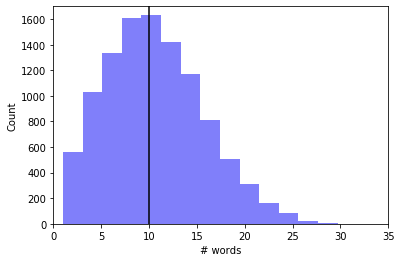

In [10]:
plt.hist(reviews_len_words, bins=20, color=(2/255, 0, 247/255, 0.5))
plt.vlines(np.median(reviews_len_words), 0, 2000)
plt.ylim([0, 1700])
plt.xlim([0, 35])

plt.xlabel('# words')
plt.ylabel('Count')
plt.savefig('figures/cnn_words_distribution.pdf', bbox_inches='tight')
# plt.show()
print(np.median(reviews_len_words))

Testing differences between positive and negative review

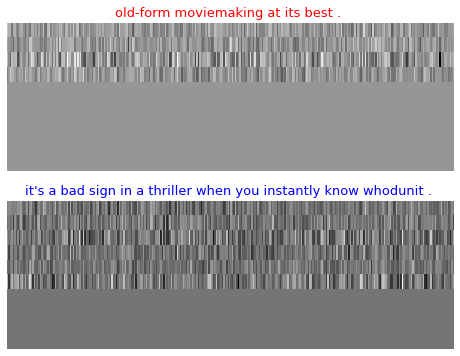

In [16]:
pos = np.random.randint(1000)
neg = np.random.randint(1000)
pos = 1235
neg = 1123

pos_r = pos_review.review.iloc[pos]
neg_r = neg_review.review.iloc[neg]

pos_review_processed = process_review(pos_r)
neg_review_processed = process_review(neg_r)

plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.imshow(pos_review_processed, cmap='gray', interpolation='nearest', aspect='auto')
title = plt.title(pos_r)
plt.setp(title, color='red', fontsize=13)
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(neg_review_processed, cmap='gray', interpolation='nearest', aspect='auto')
title = plt.title(neg_r)
plt.setp(title, color='blue', fontsize=13)
plt.axis('off')

# plt.savefig('figures/cnn_word_example.pdf', bbox_inches='tight')
plt.show()

In [17]:
processed_review = all_reviews.review.apply(lambda review: process_review(review))

X = processed_review.to_numpy().tolist()
y = all_reviews.sentiment.values

In [18]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
        """
        Create F1 metric for Keras
        From: https://stackoverflow.com/a/45305384/9511702
        """
        def recall(y_true, y_pred):
            tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = tp / (possible_positives + K.epsilon())
            return recall
        
        def precision(y_true, y_pred):
            tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = tp / (predicted_positives + K.epsilon())
            return precision
        
        precision = precision(y_true, y_pred)
        recall = recall(y_true, y_pred)
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(EMBEDDING_SIZE, MAX_WORDS, 1)),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    metrics = ['accuracy', tf.keras.metrics.AUC(), f1]
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    return model

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8)
learning_rate_reduction =  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                                patience=4, 
                                                                verbose=1, 
                                                                factor=0.5, 
                                                                min_lr=0.00001)

def train(X_train, y_train, X_test, y_test, epochs=30, batch_size=64):
    model = build_model()
    history = model.fit(X_train, 
                        y_train, 
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, learning_rate_reduction],
                        verbose=0)
    test_results = model.evaluate(X_test, y_test, batch_size)
    return history.history, model, test_results

In [20]:
from sklearn.model_selection import StratifiedKFold

def X_transform(X):
    X = tf.convert_to_tensor(X)
    X = tf.reshape(X, [X.shape[0], X.shape[2], X.shape[1], 1]) # one channel (black or white)
    return X

def y_transform(y):
    return tf.convert_to_tensor(y)

def cross_validate(X, y, split_size=3):
    results = []
    models = []
    test_results = []
    kf = StratifiedKFold(n_splits=split_size)
    for train_idx, val_idx in kf.split(X, y):
        X_train = X_transform(X[train_idx])
        y_train = y_transform(y[train_idx])
        X_test = X_transform(X[val_idx])
        y_test = y_transform(y[val_idx])
        result, model, test_result = train(X_train, y_train, X_test, y_test)
        results.append(result)
        models.append(model)
        test_results.append(test_result)
    return results, models, test_results

In [21]:
X_new = np.array(X)
y_new = np.array(y)

results, models, test_results = cross_validate(X_new, y_new)


Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
3554/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [22]:
test_results

[[0.5634996414385824, 0.72228473, 0.79889834, 0.42636997],
 [0.6211378230898315, 0.6944288, 0.7735497, 0.39125487],
 [0.6066273736967153, 0.70427686, 0.7820236, 0.42929253]]

In [23]:
def predict(model, review, max_words=MAX_WORDS, shape=(EMBEDDING_SIZE, MAX_WORDS, 1)):
    input_ = [p for p in process_review(review, max_words=max_words)]
    input_ = tf.cast(input_, tf.float32)
    input_ = tf.reshape(input_, shape)
    input_ = input_[np.newaxis, ...]
    prediction = model.predict(input_)[0][0]
    print(prediction)
    if prediction > 0.5:
        print('Positive review with probability: {:.2f}%'.format(prediction * 100))
    else:
        print('Negative review with probability: {:.2f}%'.format(100 - prediction * 100))

In [24]:
predict(models[0], 'this film is amazing. I hope to see it once again in the future.')

0.8892409
Positive review with probability: 88.92%


In [25]:
predict(models[0], 'one of the worse film i have ever seen, do not recommend!')

0.5851709
Positive review with probability: 58.52%


In [26]:
predict(models[0], """
Jason Bourne is one of the more intriguing film characters of the past decade
He methodically and purposefully found out who he was, 
who was responsible for his condition, and attempted to bring everything back together again
""")

0.6438825
Positive review with probability: 64.39%


In [27]:
for i, model in enumerate(models):
    print(f"\nModel {i}: \n")
    predict(model, "I really like this film, one of the best I've ever seen")
    predict(model, 'I like this film and recommend to everyone.')
    predict(model, 'Sometimes boring with a simple plot twist')
    predict(model, "The movie was terrible, not worth watching once again")


Model 0: 

0.47288314
Negative review with probability: 52.71%
0.74885863
Positive review with probability: 74.89%
0.010614255
Negative review with probability: 98.94%
0.112122655
Negative review with probability: 88.79%

Model 1: 

0.67105436
Positive review with probability: 67.11%
0.76965314
Positive review with probability: 76.97%
0.005232178
Negative review with probability: 99.48%
0.053104296
Negative review with probability: 94.69%

Model 2: 

0.59155554
Positive review with probability: 59.16%
0.73056304
Positive review with probability: 73.06%
0.0054814476
Negative review with probability: 99.45%
0.043402527
Negative review with probability: 95.66%


In [34]:
plt.style.use('seaborn-paper')

def plot_result(i, result):
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 4, 1)
    plt.plot(result['loss'], label='train')
    plt.plot(result['val_loss'], label='test')
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    plt.suptitle(f'Model {i}', fontsize=15)
    plt.legend(fontsize=13)
    
    auc_metrics = []
    for key, value in result.items():
        if 'auc' in key:
            auc_metrics.append(key)
    plt.subplot(1, 4, 2)
    plt.plot(result[auc_metrics[0]], label='train')
    plt.plot(result[auc_metrics[1]], label='test')
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('AUC', fontsize=14)
    plt.legend(fontsize=13)
    
    plt.subplot(1, 4, 3)
    plt.plot(result['f1'], label='train')
    plt.plot(result['val_f1'], label='test')
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel(r'$F_1$', fontsize=14)
    plt.legend(fontsize=13)
    
    plt.subplot(1, 4, 4)
    plt.plot(result['accuracy'], label='train')
    plt.plot(result['val_accuracy'], label='test')
    plt.xlabel('epoch', fontsize=14)
    plt.ylabel('accuracy', fontsize=14)
    plt.legend(fontsize=13)

    #plt.show()
    plt.savefig(f'figures/cnn_training_word_{i}.pdf', bbox_inches='tight')

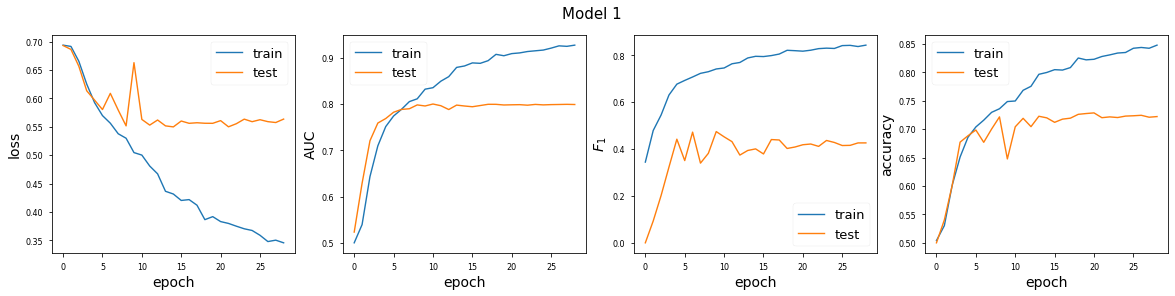

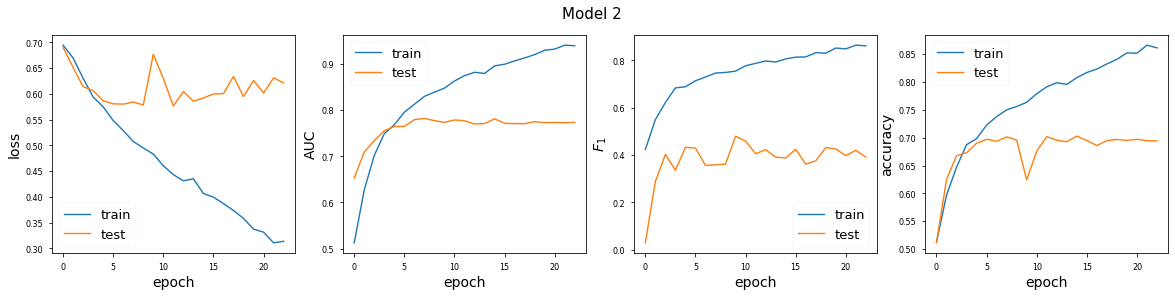

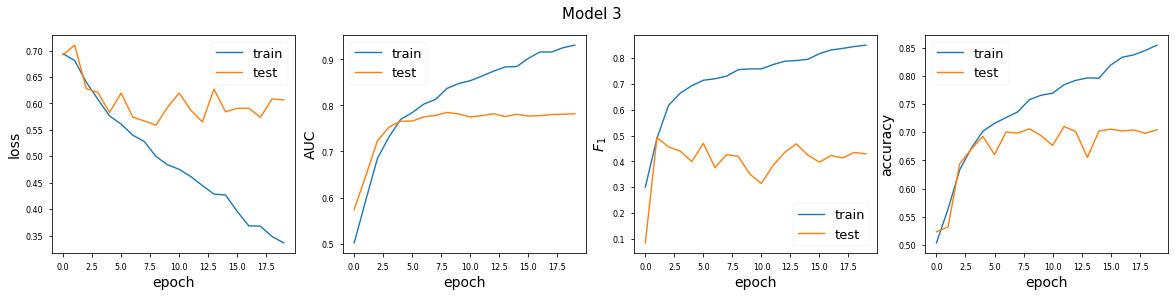

In [35]:
for i, result in enumerate(results):
    plot_result(i+1, result)

In [36]:
from tensorflow.keras.utils import model_to_dot

def save_model_architecture(filename):
    dot_model = model_to_dot(build_model(), show_shapes=True, show_layer_names=False)
    dot_model.write_pdf(filename)

In [37]:
save_model_architecture('figures/cnn_word_model_architecture.pdf')